In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import umap
import matplotlib.pyplot as plt
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('./goods_data.xlsx')
df.dropna(inplace=True)
#直接丢掉，快速试验

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [15]:
#使得int和str的StockCode可以相加
df['StockCode'] = df['StockCode'].astype(str)


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [17]:
customers = df["CustomerID"].unique().tolist()
#有顾客这么多
len(customers)

4373

In [19]:
#由于word2vec特点，选择用户id手动切分数据集，不能调包
# 打乱
random.shuffle(customers)
# 选9成的用户作为训练用户
customers_train_id = [customers[i] for i in range(round(0.9*len(customers)))]
train_df = df[df['CustomerID'].isin(customers_train_id)]
validation_df = df[~df['CustomerID'].isin(customers_train_id)]

In [20]:
#购买序列
purchases_train = []
for i in tqdm(customers_train_id):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3936/3936 [00:03<00:00, 1052.96it/s]


In [36]:
validation_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France
29,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0,France
30,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France
...,...,...,...,...,...,...,...,...
541726,581570,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,2011-12-09 11:59:00,4.95,12662.0,Germany
541727,581570,23077,DOUGHNUT LIP GLOSS,20,2011-12-09 11:59:00,1.25,12662.0,Germany
541728,581570,20750,RED RETROSPOT MINI CASES,2,2011-12-09 11:59:00,7.95,12662.0,Germany
541729,581570,22505,MEMO BOARD COTTAGE DESIGN,4,2011-12-09 11:59:00,4.95,12662.0,Germany


In [37]:
#验证item序列
purchases_val = []
for i in tqdm(validation_df.CustomerID.unique().tolist()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 1351.66it/s]


In [23]:
# train
model = Word2Vec(window = 8, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)
model.build_vocab(purchases_train, progress_per=200)
model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3547128, 3584740)

In [15]:
#如果之后不需要接着训练的话，可以
model.init_sims(replace=True)

In [24]:
print(model)

Word2Vec(vocab=3152, size=100, alpha=0.03)


In [25]:
X = model[model.wv.vocab]
X.shape

(3152, 100)

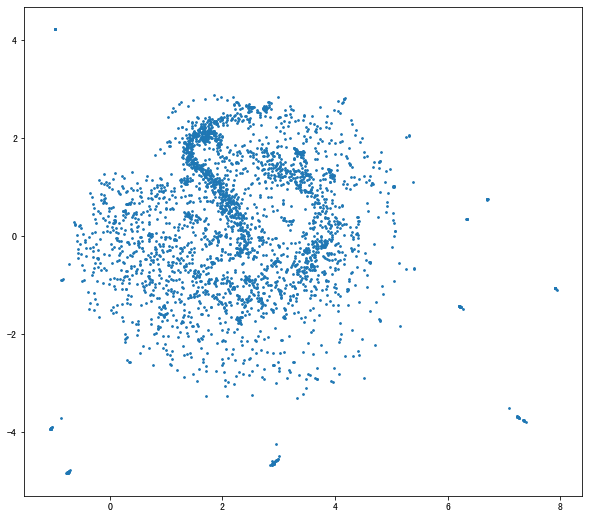

In [26]:
#降维到2，画图看相似度
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)
plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [28]:
products = train_df[["StockCode", "Description"]]
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# 创建一个产品ID和产品描述字典，以便轻松地将产品的描述映射到它的ID
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [31]:
#得到一个item，返回5个最相似的
def similar_products(v, n = 5):
    # 为输入向量最相似的
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    # 返回名字和相似度得分
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
    return new_ms        

In [32]:
#得到一个user，取他多次交互item的平均向量，然后推荐
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
    return np.mean(product_vec, axis=0)

In [38]:
#随便取一个验证用户的购买序列，买过5903个item
len(purchases_val[5])

5903

In [39]:
#向量100维
aggregate_vectors(purchases_val[5]).shape

(100,)

In [40]:
#为这个用户推荐股票
similar_products(aggregate_vectors(purchases_val[0]))

[('SET/6 RED SPOTTY PAPER CUPS', 0.7034299373626709),
 ('ROUND SNACK BOXES SET OF 4 FRUITS ', 0.6960235834121704),
 ('MINI PAINT SET VINTAGE ', 0.6951864957809448),
 ('ROUND SNACK BOXES SET OF4 WOODLAND ', 0.6936846971511841),
 ('RED TOADSTOOL LED NIGHT LIGHT', 0.6896371841430664)]

In [42]:
#如果只是考虑这个用户最近3次的行为
similar_products(aggregate_vectors(purchases_val[0][-3:]))

[('ALARM CLOCK BAKELIKE GREEN', 0.8298426866531372),
 ('ALARM CLOCK BAKELIKE IVORY', 0.7962035536766052),
 ('ALARM CLOCK BAKELIKE RED ', 0.7821028232574463),
 ('ALARM CLOCK BAKELIKE CHOCOLATE', 0.7752372622489929),
 ('ALARM CLOCK BAKELIKE ORANGE', 0.762324333190918)]